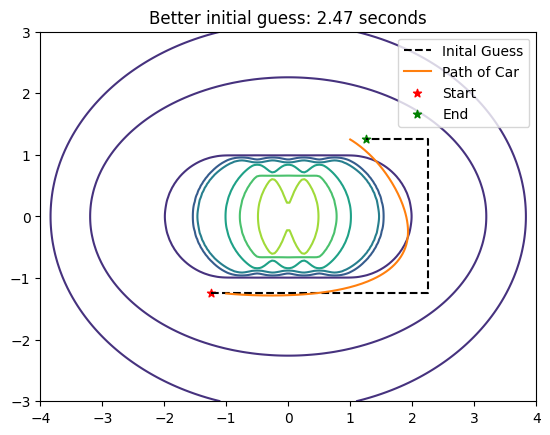

2.473254759114629

In [65]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp

def obstacle(x,y,W1=1,r=(1,1),c=(0,0)):
    '''
    Define an area that will represent an obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

def C(x, y, W1=1):
    '''
    Uses the obstacle function to combine all of our ellipses that we used to make our track
    '''
    return obstacle(x, y, W1, r=(15,10)) - obstacle(x, y, W1,r=(10,5)) + obstacle(x, y, W1) + obstacle(x, y, W1, c=(1,0)) + obstacle(x, y, W1, c=(-1,0)) + obstacle(x, y, W1, c=(.5,0)) + obstacle(x, y, W1, c=(-.5,0))

def C_dx(x, y, W1=1):
    '''
    derivative with respect to x of the C function
    '''
    return obstacle_dx(x, y, W1, r=(15,10)) - obstacle_dx(x, y, W1,r=(10,5)) + obstacle_dx(x, y, W1) + obstacle_dx(x, y, W1, c=(1,0)) + obstacle_dx(x, y, W1, c=(-1,0)) + obstacle_dx(x, y, W1, c=(.5,0)) + obstacle_dx(x, y, W1, c=(-.5,0))

def C_dy(x, y, W1=1):
    '''
    derivative with respect to y of the C function
    '''
    return obstacle_dy(x, y, W1, r=(15,10)) - obstacle_dy(x, y, W1,r=(10,5)) + obstacle_dy(x, y, W1) + obstacle_dy(x, y, W1, c=(1,0)) + obstacle_dy(x, y, W1, c=(-1,0)) + obstacle_dy(x, y, W1, c=(.5,0)) + obstacle_dy(x, y, W1, c=(-.5,0))

def K(delta, vx, vy, lmb = 20, cushion=.1, L = .05, M = 3.):
    '''Integral constraint due to centripetal acceleration'''
    return (cushion / (delta - np.arctan(L*M/(vx**2 + vy**2)))) ** lmb

def K_dvx(delta, vx, vy, lmb=20, cushion=.1, L=.05, M=3.):
    ''' derivative of K with respect to vx'''
    v2 = vx**2 + vy**2
    lm_v2 = L*M/(v2)
    numerator = -2*cushion*lmb*L*M*vx*(cushion/(delta-np.arctan(lm_v2)))**(lmb-1)
    denominator = (v2**2)*(lm_v2**2 + 1)*(delta - np.arctan(lm_v2))**2
    return numerator / denominator

def K_dvy(delta, vx, vy, lmb=20, cushion=.1, L=.05, M=3.):
    ''' derivative of K with respect to vy'''
    v2 = vx**2 + vy**2
    lm_v2 = L*M/(v2)
    numerator = -2*cushion*lmb*L*M*vy*(cushion/(delta-np.arctan(lm_v2)))**(lmb-1)
    denominator = (v2**2)*(lm_v2**2 + 1)*(delta - np.arctan(lm_v2))**2
    return numerator / denominator

def K_ddelta(delta, vx, vy, lmb=20, cushion=.1, L=.5, M=3.):
    ''' derivative of K with respect to delta '''
    return -lmb*(cushion / (delta - np.arctan(L*M/(vx**2 + vy**2))))**(lmb+1) / cushion

def plot_track():
    X,Y = np.meshgrid(np.linspace(-5,5,600),np.linspace(-5,5,600))
    Z = C(X,Y, W1=3)

    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(X,Y,Z,edgecolor=None,linewidth=0)
    ax.set_zlim(0,3)
    ax.view_init(elev=84,azim=90)

    ax2 = fig.add_subplot(122)
    ax2.contour(X, Y, Z)
    ax2.set_xbound([-4,4])
    ax2.set_ybound([-7,7])

    plt.axis('off')
    plt.show()

def naive_system():

    W2 = .05
    n = 200
    t = np.linspace(0, 1, n)

    C0 = C(0,0)

    def ode(t, s, p):
        return p[0] * np.array([
            s[2],
            s[3],
            1/(2*W2)*s[6],
            1/(2*W2)*s[7],
            C_dx(s[0], s[1]),
            C_dy(s[0], s[1]),
            -s[4],
            -s[5]
        ])

    def bc(ya, yb, p):
        return np.array([
            ya[0] + 1, ya[1] + 1.25, ya[2], ya[3], yb[0] - 1, yb[1] - 1.25, yb[2], yb[3],

            # H(tf) = 0
            yb[4]*yb[2] + yb[5]*yb[3] + yb[6]**2/(2*W2) + yb[7]**2/(2*W2) - (1 + C0 + (yb[6]**2+yb[7]**2/(4*W2)))
        ])

    guess = np.ones((8, n))

    path_x = np.concatenate((np.linspace(-1.25, 2.25, 100), 2.25*np.ones(75), np.linspace(1.25, 2.25, 25)[::-1]))
    path_y = np.concatenate((-1.25*np.ones(100), np.linspace(-1.25,1.25,75), 1.25*np.ones(25)))


    guess[0] = path_x
    guess[1] = path_y
    p0 = np.array([7])

    sol = solve_bvp(ode, bc, t, guess, p0, max_nodes=30000)

    X = np.linspace(-4, 4, 200)
    Y = np.linspace(-3, 3, 200)
    X, Y = np.meshgrid(X, Y)
    Z = C(X, Y)


    plt.plot(path_x, path_y, "--k", label="Inital Guess")
    plt.contour(X, Y, Z)
    plt.plot(sol.sol(t)[0], sol.sol(t)[1], "tab:orange", label="Path of Car")
    plt.scatter(-1.25, -1.25, marker="*", color="red", label="Start")
    plt.scatter(1.25, 1.25, marker="*", color="green", label="End")
    plt.xlim([-4,4])
    plt.ylim([-3,3])
    plt.legend()
    plt.title(f"Better initial guess: {sol.p[0]:.2F} seconds")
    # plt.savefig("better_guess")
    plt.show()

    return sol.p[0]

naive_system()

<ipython-input-65-488e7f5bd061>:34: RuntimeWarning: overflow encountered in power
  numer = -40* W1 * (x-c[0])*(circle)**19
<ipython-input-65-488e7f5bd061>:35: RuntimeWarning: overflow encountered in power
  denom = r[0]*((circle)**20 + 1)**2
<ipython-input-65-488e7f5bd061>:35: RuntimeWarning: overflow encountered in square
  denom = r[0]*((circle)**20 + 1)**2
<ipython-input-65-488e7f5bd061>:37: RuntimeWarning: invalid value encountered in divide
  return numer / denom
<ipython-input-65-488e7f5bd061>:34: RuntimeWarning: overflow encountered in multiply
  numer = -40* W1 * (x-c[0])*(circle)**19
<ipython-input-65-488e7f5bd061>:52: RuntimeWarning: overflow encountered in power
  numer = -40 * W1 * (y-c[1])*(circle)**19
<ipython-input-65-488e7f5bd061>:53: RuntimeWarning: overflow encountered in power
  denom = r[1]*((circle)**20 + 1)**2
<ipython-input-65-488e7f5bd061>:53: RuntimeWarning: overflow encountered in square
  denom = r[1]*((circle)**20 + 1)**2
<ipython-input-65-488e7f5bd061>:55:

Optimal time -1130.321760729538
       message: A singular Jacobian encountered when solving the collocation system.
       success: False
        status: 2
             x: [ 0.000e+00  5.025e-03 ...  9.950e-01  1.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x7981fc31f060>
             p: [ 1.130e+03]
             y: [[ 1.985e+05 -2.156e+17 ... -3.757e+17 -1.531e+07]
                 [ 2.450e+06 -4.918e+17 ...  2.760e+17  3.205e+06]
                 ...
                 [-1.161e+22 -9.759e+21 ... -3.828e+17  8.240e-01]
                 [ 1.459e+22  1.562e+22 ...  5.193e+18  8.240e-01]]
            yp: [[ 1.286e+07  2.049e+23 ...  1.918e+23  1.935e+23]
                 [ 9.314e+02  2.628e+22 ... -1.428e+23 -1.404e+23]
                 ...
                 [ 3.060e+47  5.959e+47 ... -1.877e+42 -1.544e+02]
                 [ 5.812e+30  2.268e+47 ...  2.032e+42 -9.937e+24]]
 rms_residuals: [       nan        nan ...        nan        nan]
         niter: 1


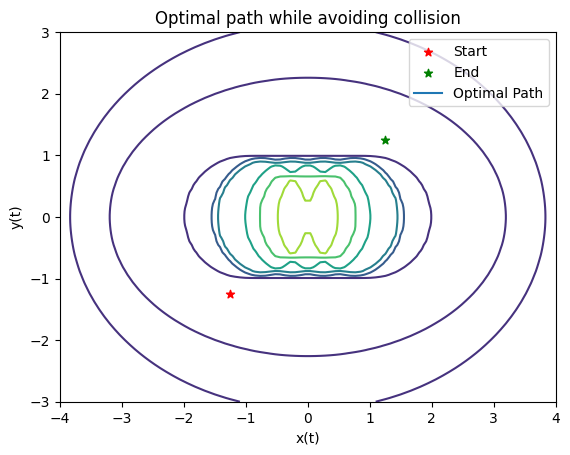

In [85]:
def constraints_path():
    eps = 1e-5
    # Impose constants values for our parameters
    L = 0.05
    M = 3
    W1 = 1
    W2 = 0.05
    W3 = 1
    W4 = 1
    W5 = 1

    # Element 1: The ODE Function
    def ode(t,y,p):
        '''defines the ODE system''',
        u_acc =  1/(2*W1) * (y[8] * np.cos(y[4]) + y[9] * np.sin(y[4]))
        return p[0] * np.array([y[2],
                                y[3],
                                u_acc * np.cos(y[4]),
                                u_acc * np.sin(y[4]),
                                (np.sqrt(y[2]**2 + y[3]**2)) * np.tan(y[5])/ L,
                                (1/(2*W2)) * (y[11]),
                                100 * C_dx(y[0], y[1]),
                                100 * C_dy(y[0], y[1]),
                                -y[6] - y[10] * (y[2] /(np.sqrt(y[2]**2 + y[3]**2)) * np.tan(y[5] / L)) + K_dvx(y[5], y[2], y[3]),
                                -y[7] - y[10] * (y[3] /(np.sqrt(y[2]**2 + y[3]**2)) * np.tan(y[5] / L)) + K_dvy(y[5], y[2], y[3]),
                                y[8] * u_acc * np.sin(y[4]) - y[9] * u_acc * np.cos(y[4]),
                                (-y[10]/L) * (np.sqrt(y[2]**2 + y[3]**2)) * 1/(np.cos(y[5]/L)**2) + K_ddelta(y[5], y[2], y[3])])

    # Element 2: The Boundary Conditions
    def bc(ya, yb, p):
        ''' defines the boundary conditions'''
        u_acc =  1/(2*W1) * (yb[8] * np.cos(yb[4]) + yb[9] * np.sin(yb[4]))
        u_turn = (1/(2*W2)) * (yb[11])
        lag = 1 + 1000* C(yb[0],yb[1]) + W1 * u_acc**2 + W2 * u_turn**2 + ((yb[2]**2 + yb[3]**2) / L * np.tan(yb[5]) - M)**(-70)
        hamiltonian_condition  = (np.ones(6) * p).T@ np.array([yb[2],
                                yb[3],
                                1/(2*W1) * (yb[8] * np.cos(yb[4]) + yb[9] * np.sin(yb[4])) * np.cos(yb[4]),
                                1/(2*W1) * (yb[8]  * np.cos(yb[4]) + yb[9] * np.sin(yb[4])) * np.sin(yb[4]),
                                (np.sqrt(yb[2]**2 + yb[3]**2)) * np.tan(yb[5] / L),
                                (1/(2*W2)) * (yb[11])]) -  lag

        return np.array([ya[0] + 1, ya[1] + 1.1, ya[2], ya[3], ya[4], ya[5], yb[0] -1, yb[1] + 1.1, yb[8], yb[9], yb[10], yb[11],hamiltonian_condition])

                    # Define domain and initial guesses
    t = np.linspace(0,1,200)
    y0 = np.ones((12, len(t)))
    path_x = np.concatenate((np.linspace(-1.25, 2.25, 100), 2.25*np.ones(75), np.linspace(1.25, 2.25, 25)[::-1]))
    path_y = np.concatenate((-1.25*np.ones(100), np.linspace(-1.25,1.25,75), 1.25*np.ones(25)))


    y0[0] = path_x
    y0[1] = path_y
    p0 = np.array([1])

    # Solve the bvp and print optimal time
    sol = solve_bvp(ode, bc,t,y0,p0)
    print("Optimal time", -sol.p[0]*t[-1])

    # Create meshgrid to plot obstacle
    x = np.linspace(-4,4,100)
    y = np.linspace(-3,3,100)
    X, Y = np.meshgrid(x,y)
    print(sol)
    # Plot optimal path and obstacle
    plt.plot(sol.y[0],sol.y[1], label = 'Optimal Path')
    # print(sol.y)
    plt.contour(X,Y, C(X,Y))
    plt.xlabel('x(t)')
    plt.ylabel('y(t)')
    plt.title('Optimal path while avoiding collision')
    plt.legend()
    plt.show()
plt.scatter(-1.25, -1.25, marker="*", color="red", label="Start")
plt.scatter(1.25, 1.25, marker="*", color="green", label="End")
plt.xlim([-4,4])
plt.ylim([-3,3])
plt.legend()
constraints_path()